## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations
from test_results import test_results, score

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import EDA_functions as EDA
import cleaning_functions as cleaning

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load in the data
train = pd.read_csv('data/training.csv')

### EDA

In [3]:
train.sample(5)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
26836,39872,No,0,2,34.919417,-0.991928,2,3,2,2
38036,56556,No,0,2,30.581187,-1.251661,2,2,2,2
9640,14399,No,0,2,37.697094,-1.511395,1,3,1,2
10818,16153,No,0,2,18.570018,-0.559039,1,3,1,2
3285,4860,Yes,0,1,29.720754,1.518828,1,1,1,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
# make a copy of training set for EDA purpose

eda = train.copy()

In [6]:
# change datatypes, drop ID column

colsToCat = ["Promotion", "V1", "V4", "V5", "V6", "V7"]
eda = cleaning.change_dtypes(eda, cols_to_category=colsToCat)
eda.drop('ID', axis=1, inplace=True)

In [7]:
# check
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 9 columns):
Promotion    84534 non-null category
purchase     84534 non-null int64
V1           84534 non-null category
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null category
V5           84534 non-null category
V6           84534 non-null category
V7           84534 non-null category
dtypes: category(6), float64(2), int64(1)
memory usage: 2.4 MB


In [8]:
eda.describe()

,purchase,V2,V3
count,84534.000000,84534.000000,84534.000000
mean,0.012303,29.973600,0.000190
std,0.110234,5.010626,1.000485
min,0.000000,7.104007,-1.684550
25%,0.000000,26.591501,-0.905350
50%,0.000000,29.979744,-0.039572
75%,0.000000,33.344593,0.826206
max,1.000000,50.375913,1.691984


In [9]:
# check purchase distribution

display(eda['purchase'].value_counts())
print("proportion of purchases (%)", round(eda['purchase'].value_counts()[1] / len(eda) *100, 2))

0    83494
1     1040
Name: purchase, dtype: int64

proportion of purchases (%) 1.23


In [29]:
eda_grouped = eda.groupby('Promotion').mean()
eda_grouped

,purchase,V2,V3
Promotion,,,
No,0.007565,29.976876,-0.007099
Yes,0.017019,29.970338,0.007446


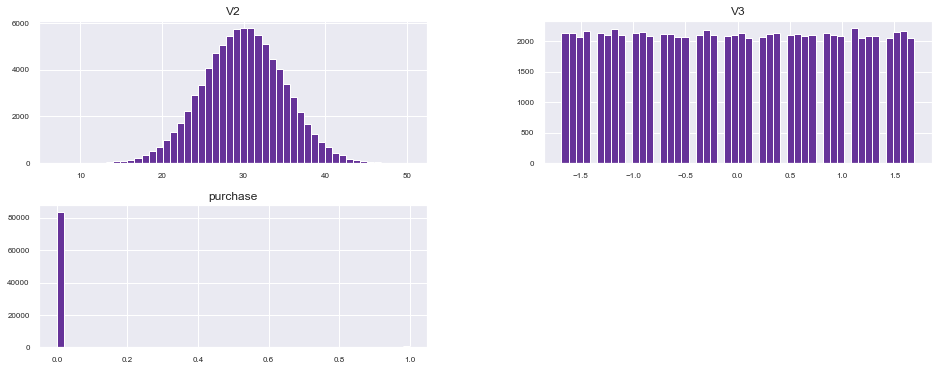

In [10]:
# look at numeric variables

EDA.plot_num_hist(eda, bins=50, figsize=(16,6))

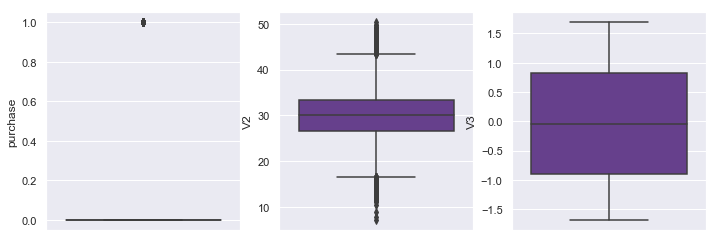

In [11]:
EDA.plot_num_box(eda, figsize=(16,4))

In [12]:
# look at categorical variables

eda.describe(include = 'category')

,Promotion,V1,V4,V5,V6,V7
count,84534,84534,84534,84534,84534,84534
unique,2,4,2,4,4,2
top,Yes,1,2,3,3,2
freq,42364,31631,57450,32743,21186,59317


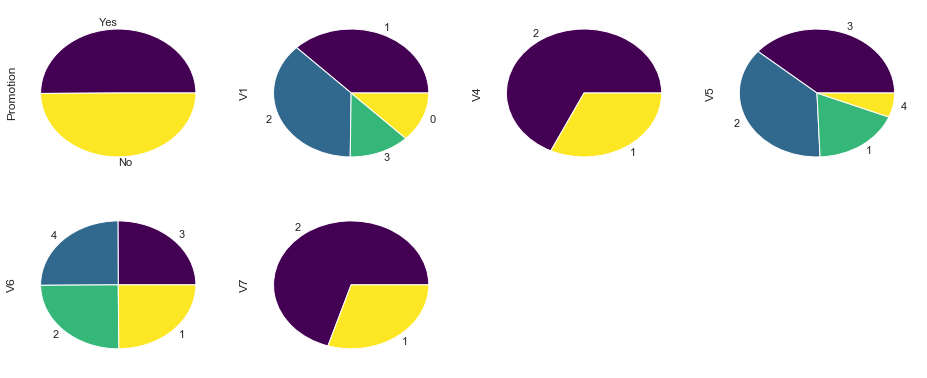

In [13]:
EDA.plot_cat_pies(eda, figsize=(16, 10))

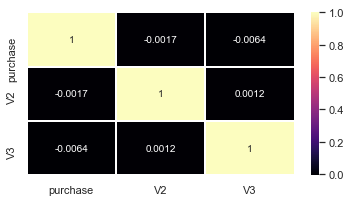

In [19]:
# check correlations for numerical columns

EDA.plot_num_corrMap(eda, figsize=(6, 3))

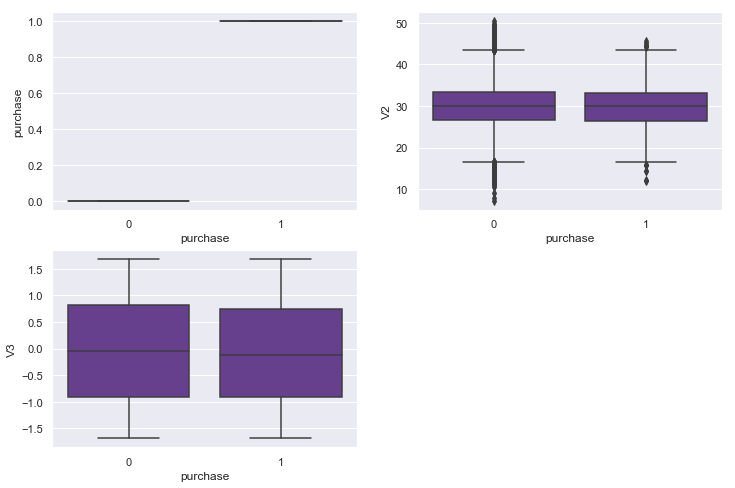

In [22]:
EDA.plot_num_corrBox(eda, 'purchase', figsize=(12, 8))

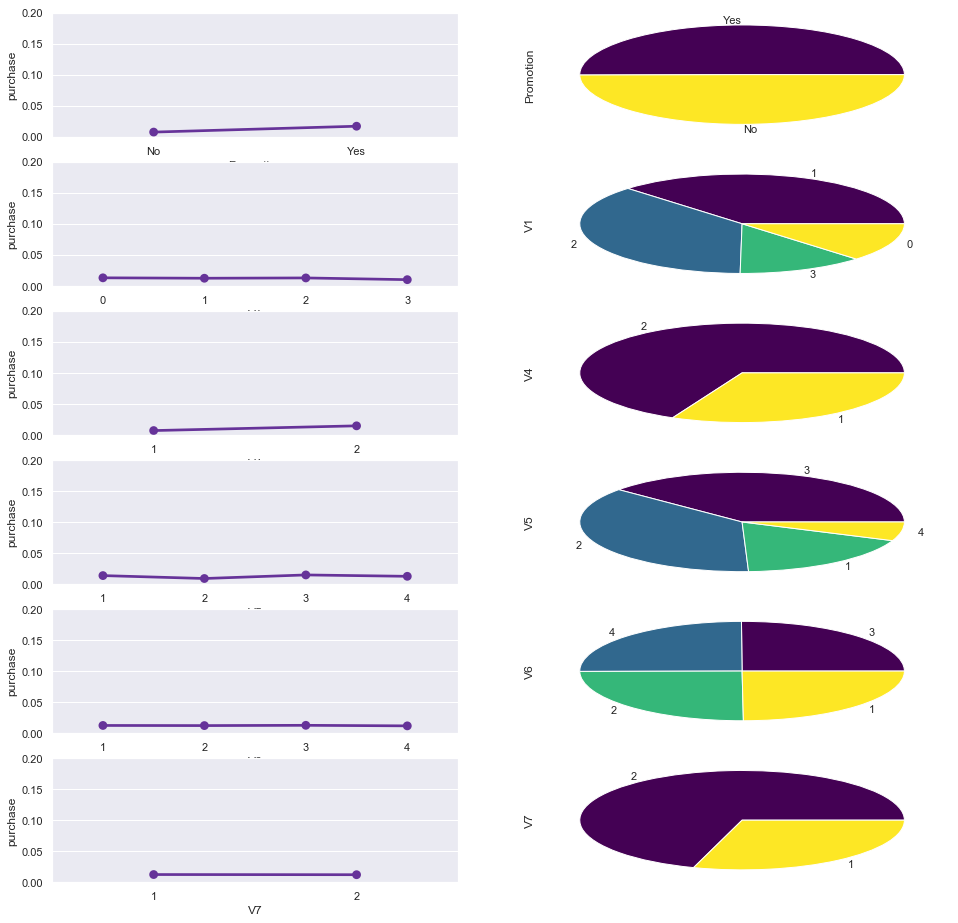

In [26]:
# check correlations for categorical columns

EDA.plot_cat_corrPoint(eda, 'purchase', figsize=(16, 16), ylim=[0,0.2])

In [14]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [15]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

FileNotFoundError: File b'Test.csv' does not exist